In [1]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import random
import shutil

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, TrivialAugmentWide, Compose, Normalize

from torch import nn
from torch.nn import Module
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import ReLU
from torch.nn import LogSoftmax
from torch.nn import BatchNorm2d
from torch.nn import LSTM
from torch import flatten
from torchmetrics import CharErrorRate
import torch.nn.functional as F
from torch.nn import CTCLoss
torch.cuda.empty_cache()

# Prepare data

### Alphabet class

In [3]:
class Alphabet(object):
    def __init__(self, folder_path):
        self.symbol2idx = {}
        self.idx2symbol = []
        self._len = 0
        self.make_alphabet(folder_path)
        
    def add_symbol(self, s):
        if s not in self.symbol2idx:
            self.idx2symbol.append(s)
            self.symbol2idx[s] = self._len
            self._len += 1
            
    def make_alphabet(self, folder_path):
        assert os.path.exists(folder_path)
        for _, _, files in os.walk(folder_path):
            for file_name in files:
                file_name = file_name.split('.')[0]
                for symbol in file_name:
                    self.add_symbol(symbol)
        
    def __len__(self):
        return self._len
    
    def encode(self, label):
        ids = torch.zeros([len(label), len(self)], dtype=torch.float32)
        for pos, symbol in enumerate(label):
            ids[pos, self.symbol2idx[symbol]] = 1.
        return ids
    
    def decode(self, ids):
        idxs = ids.argmax(dim=2).tolist()
        labels = [''.join([self.idx2symbol[i] for i in b]) for b in idxs]
        return labels

In [4]:
img_dir = './samples/'

alphabet = Alphabet(img_dir)

### Dataset class

In [5]:
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_labels = []
        for _, _, files in os.walk(img_dir):
            for file_ in files:
                self.img_labels.append(file_)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        filename = self.img_labels[idx]
        img_path = os.path.join(self.img_dir, filename)
        image = Image.open(img_path).convert('RGB')
        label = alphabet.encode(filename.split('.')[0])
        if self.transform:
            image = self.transform(image)
        return image, label

### Train/Test split

In [6]:
all_files = []
for _, _, files in os.walk(img_dir):
    for file_ in files:
        all_files.append(file_)
        
random.shuffle(all_files)
border = int(0.8 * len(all_files))
train_files = all_files[:border]
test_files = all_files[border:]

In [7]:
train_data_dir = 'data/train/'
test_data_dir = 'data/test/'

if not os.path.exists(train_data_dir):
    os.makedirs(train_data_dir)
    for file in train_files:
        shutil.copy(os.path.join(img_dir, file), train_data_dir)

if not os.path.exists(test_data_dir):
    os.makedirs(test_data_dir)
    for file in test_files:
        shutil.copy(os.path.join(img_dir, file), test_data_dir)

### Find mean and std of dataset

In [8]:
dataset = CustomImageDataset(img_dir=img_dir,
                                   transform=Compose([
                                            #TrivialAugmentWide(),
                                            ToTensor(),
                                   ]))

In [9]:
data_loader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=4)

In [10]:
nimages = 0
mean = 0.0
var = 0.0
for i_batch, batch_target in enumerate(data_loader):
    batch = batch_target[0]
    # Rearrange batch to be the shape of [B, C, W * H]
    batch = batch.view(batch.size(0), batch.size(1), -1)
    # Update total number of images
    nimages += batch.size(0)
    # Compute mean and std here
    mean += batch.mean(2).sum(0) 
    var += batch.var(2).sum(0)

mean /= nimages
var /= nimages
std = torch.sqrt(var)

print(mean)
print(std)

tensor([0.7152, 0.7152, 0.7152])
tensor([0.3135, 0.3135, 0.3135])


In [11]:
train_dataset = CustomImageDataset(img_dir=train_data_dir,
                                   transform=Compose([
                                            TrivialAugmentWide(),
                                            ToTensor(),
                                            Normalize(mean=[0.7152, 0.7152, 0.7152], std=[0.3135, 0.3135, 0.3135]),
                                   ]))

test_dataset = CustomImageDataset(img_dir=test_data_dir,
                                  transform=Compose([
                                            ToTensor(),
                                            Normalize(mean=[0.7152, 0.7152, 0.7152], std=[0.3135, 0.3135, 0.3135]),
                                 ]))

In [12]:
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=6)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=6)

## Create Model

In [13]:
class Bidirectional_LSTM(torch.nn.Module):
    def __init__(self, class_num, hidden_unit):
        super(Bidirectional_LSTM, self).__init__()
        
        self.LSTM1 = torch.nn.LSTM(2048, hidden_unit, bidirectional=True)
        self.embedding1 = torch.nn.Linear(hidden_unit * 2, 2048)
        self.LSTM2 = torch.nn.LSTM(2048, hidden_unit, bidirectional=True)
        self.embedding2 = torch.nn.Linear(hidden_unit * 2, class_num)

    def forward(self, x):
        x = self.LSTM1(x)   # LSTM output: output, (h_n, c_n)
        T, b, h = x[0].size()   # x[0]: (seq_len, batch, num_directions * hidden_size)
        x = self.embedding1(x[0].view(T * b, h))  # pytorch view() reshape as [T * b, nOut]
        x = x.view(T, b, -1)  # [seq_len, b, 512]
        
        x = self.LSTM2(x)
        T, b, h = x[0].size()
        x = self.embedding2(x[0].view(T * b, h))
        x = x.view(T, b, -1)
        
        return x


In [14]:
class CapchaNet(Module):
    def __init__(self, alphabet_len):
        super(CapchaNet, self).__init__()
        
        self.conv1 = Conv2d(3, 128, (3, 3), stride=2) # 99x24
        self.bn1 = BatchNorm2d(128)
        self.conv2 = Conv2d(128, 256, (3, 3), stride=2) # 48x11
        self.bn2 = BatchNorm2d(256)
        self.conv3 = Conv2d(256, 512, (3, 3), stride=2) # 23x5
        self.bn3 = BatchNorm2d(512)
        self.conv4 = Conv2d(512, 1024, (3, 3), stride=2) # 11x2
        self.bn4 = BatchNorm2d(1024)
        self.conv5 = Conv2d(1024, 2048, (2, 2), stride=(1, 2)) # 5X1
        self.bn5 = BatchNorm2d(2048)
        #self.conv6 = Conv2d(2048, 4096, (1, 1)) # 5X1
        #self.bn6 = BatchNorm2d(4096)
        self.rnn = Bidirectional_LSTM(alphabet_len, 2048)
    
    def forward(self, x):
        
        x = self.bn1(F.relu(self.conv1(x)))
        x = self.bn2(F.relu(self.conv2(x)))
        x = self.bn3(F.relu(self.conv3(x)))
        x = self.bn4(F.relu(self.conv4(x)))
        x = self.bn5(F.relu(self.conv5(x)))
        #x = self.bn6(F.relu(self.conv6(x)))
        
        x = x.squeeze(2)  # remove h dimension
        x = x.permute(2, 0, 1)  # [w, b, c] = [seq_len, batch, input_size]
        x = self.rnn(x)
        
        x = x.permute(1, 0, 2)
        output = F.log_softmax(x, dim=2)
        
        return output

## Train model

In [15]:
import string
import math
from torch.optim import lr_scheduler

model = CapchaNet(len(alphabet))
criterion = nn.CrossEntropyLoss()

In [16]:
#grad_clip = 0.1
best_cer = 1.0
start_saving_epoch = 50
lr = torch.tensor(1e-4)
optim = torch.optim.Adam(model.parameters(), lr=lr)
# optim = torch.optim.RMSprop(model.parameters(), lr=lr)
scheduler = lr_scheduler.ReduceLROnPlateau(optim, mode='min', factor=0.55, patience=9, verbose=True)
# scheduler = lr_scheduler.StepLR(optim, step_size=40, gamma=0.25)
# milestones = [44, 69, 87, 100, 108, 116]
# scheduler = lr_scheduler.MultiStepLR(optim, milestones=milestones , gamma=0.3)

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [18]:
model.to(device)

CapchaNet(
  (conv1): Conv2d(3, 128, kernel_size=(3, 3), stride=(2, 2))
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2))
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2))
  (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(512, 1024, kernel_size=(3, 3), stride=(2, 2))
  (bn4): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(1024, 2048, kernel_size=(2, 2), stride=(1, 2))
  (bn5): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (rnn): Bidirectional_LSTM(
    (LSTM1): LSTM(2048, 2048, bidirectional=True)
    (embedding1): Linear(in_features=4096, out_features=2048, bias=True)
    (LSTM2): LSTM(2048, 2048, bidirectional=True)
    (embedding2): L

In [19]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [20]:
def character_error_rate(preds, labels):
    assert len(preds) == len(labels)
    errors = 0
    for pred, label in zip(preds, labels):
        for p, l in zip(pred, label):
            errors += int(p != l)
    return errors / (len(labels) * len(labels[0]))

In [21]:
def train(model, epoch):
    
    total_loss, total_val_loss, cer = 0, 0, 0
    
    model.train()
    for data, targets in train_loader:
        
        data, targets = data.to(device), targets.to(device)
        output = model(data)
        optim.zero_grad()
        loss = criterion(output, targets)
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optim.step()
        total_loss += loss.item()
    
    model.eval()
    with torch.no_grad():
        for data, targets in test_loader:
            
            data, targets = data.to(device), targets.to(device)
            preds = model(data)
            val_loss = criterion(preds, targets)
            total_val_loss += val_loss.item()
            labels = alphabet.decode(targets)
            pred_labels = alphabet.decode(preds)
            cer += character_error_rate(pred_labels, labels)
            
    total_loss /= len(train_loader)
    total_val_loss /= len(test_loader)
    cer /= len(test_loader)
    
    scheduler.step(total_val_loss)
    
    print('[Epoch {:3d}]:  lr {:02.7f} | train loss {:5.5f} | val loss {:5.5f} | val CER {:5.5f}'.format(
                epoch, get_lr(optim), total_loss, total_val_loss, cer))
    global best_cer
    if epoch > start_saving_epoch and cer < best_cer:
        best_cer = cer
        print(f'[Epoch {epoch:3d}]: best CER: {cer:5.5f}, saving best model...')
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optim.state_dict(),
            'loss': criterion,
            }, 'outputs/best_model.pth')
    
    return total_loss, total_val_loss

In [22]:
loss_curve_train, loss_curve_test = [], []

In [23]:
%%time

for epoch in range(1, 251):
    train_loss, test_loss = train(model, epoch)
    loss_curve_train.append(train_loss)
    loss_curve_test.append(test_loss)

[Epoch   1]:  lr 0.0001000 | train loss 0.40250 | val loss 0.28252 | val CER 0.72857
[Epoch   2]:  lr 0.0001000 | train loss 0.29954 | val loss 0.16394 | val CER 0.53274
[Epoch   3]:  lr 0.0001000 | train loss 0.25241 | val loss 0.12351 | val CER 0.37470
[Epoch   4]:  lr 0.0001000 | train loss 0.21206 | val loss 0.10215 | val CER 0.31399
[Epoch   5]:  lr 0.0001000 | train loss 0.20986 | val loss 0.09109 | val CER 0.29940
[Epoch   6]:  lr 0.0001000 | train loss 0.19598 | val loss 0.06871 | val CER 0.19315
[Epoch   7]:  lr 0.0001000 | train loss 0.16735 | val loss 0.07092 | val CER 0.19345
[Epoch   8]:  lr 0.0001000 | train loss 0.17679 | val loss 0.06890 | val CER 0.18780
[Epoch   9]:  lr 0.0001000 | train loss 0.17520 | val loss 0.07459 | val CER 0.22440
[Epoch  10]:  lr 0.0001000 | train loss 0.15684 | val loss 0.06279 | val CER 0.18571
[Epoch  11]:  lr 0.0001000 | train loss 0.15876 | val loss 0.05617 | val CER 0.14256
[Epoch  12]:  lr 0.0001000 | train loss 0.15383 | val loss 0.0563

[Epoch  89]:  lr 0.0000166 | train loss 0.07959 | val loss 0.03949 | val CER 0.02649
[Epoch  90]:  lr 0.0000166 | train loss 0.08773 | val loss 0.03898 | val CER 0.02411
[Epoch  91]:  lr 0.0000166 | train loss 0.08243 | val loss 0.03848 | val CER 0.01696
[Epoch  91]: best CER: 0.01696, saving best model...
[Epoch  92]:  lr 0.0000166 | train loss 0.08695 | val loss 0.03851 | val CER 0.02113
[Epoch  93]:  lr 0.0000166 | train loss 0.07978 | val loss 0.03882 | val CER 0.02619
[Epoch  94]:  lr 0.0000166 | train loss 0.08569 | val loss 0.03927 | val CER 0.02440
[Epoch  95]:  lr 0.0000166 | train loss 0.08982 | val loss 0.03982 | val CER 0.02798
[Epoch  96]:  lr 0.0000166 | train loss 0.08547 | val loss 0.03944 | val CER 0.02381
[Epoch  97]:  lr 0.0000166 | train loss 0.08744 | val loss 0.03939 | val CER 0.02381
[Epoch  98]:  lr 0.0000166 | train loss 0.08297 | val loss 0.03981 | val CER 0.02202
[Epoch  99]:  lr 0.0000166 | train loss 0.08567 | val loss 0.04006 | val CER 0.02202
[Epoch 100]:

[Epoch 178]:  lr 0.0000001 | train loss 0.08123 | val loss 0.03894 | val CER 0.01607
[Epoch 179]:  lr 0.0000001 | train loss 0.08286 | val loss 0.03912 | val CER 0.01786
[Epoch 180]:  lr 0.0000001 | train loss 0.07874 | val loss 0.03903 | val CER 0.01607
Epoch 00181: reducing learning rate of group 0 to 7.6622e-08.
[Epoch 181]:  lr 0.0000001 | train loss 0.07945 | val loss 0.03912 | val CER 0.01786
[Epoch 182]:  lr 0.0000001 | train loss 0.08341 | val loss 0.03900 | val CER 0.01696
[Epoch 183]:  lr 0.0000001 | train loss 0.07611 | val loss 0.03931 | val CER 0.01696
[Epoch 184]:  lr 0.0000001 | train loss 0.08251 | val loss 0.03913 | val CER 0.01696
[Epoch 185]:  lr 0.0000001 | train loss 0.07963 | val loss 0.03916 | val CER 0.01786
[Epoch 186]:  lr 0.0000001 | train loss 0.07991 | val loss 0.03906 | val CER 0.01607
[Epoch 187]:  lr 0.0000001 | train loss 0.08252 | val loss 0.03903 | val CER 0.01696
[Epoch 188]:  lr 0.0000001 | train loss 0.07965 | val loss 0.03917 | val CER 0.01607
[Ep

### Load best model


In [48]:
saved_dict = torch.load('outputs/best_model.pth')
model = CapchaNet(len(alphabet))
model.load_state_dict(saved_dict['model_state_dict'])
model.to(device)

CapchaNet(
  (conv1): Conv2d(3, 128, kernel_size=(3, 3), stride=(2, 2))
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2))
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2))
  (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(512, 1024, kernel_size=(3, 3), stride=(2, 2))
  (bn4): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(1024, 2048, kernel_size=(2, 2), stride=(1, 2))
  (bn5): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (rnn): Bidirectional_LSTM(
    (LSTM1): LSTM(2048, 2048, bidirectional=True)
    (embedding1): Linear(in_features=4096, out_features=2048, bias=True)
    (LSTM2): LSTM(2048, 2048, bidirectional=True)
    (embedding2): L

### Best CER  = 1,429 %

## Model error analysis

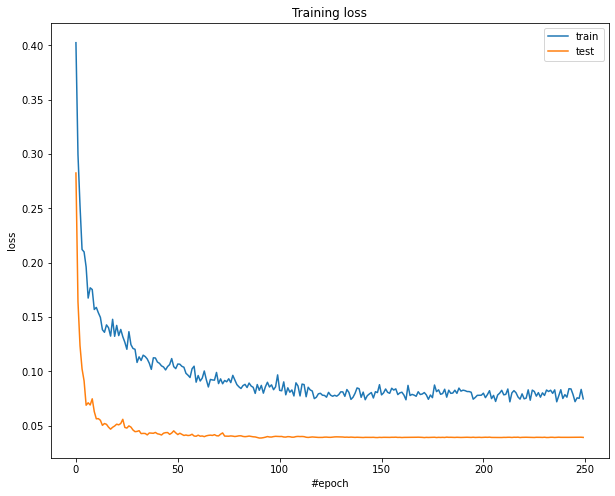

In [43]:
# Visualize loss
plt.figure(figsize=(10, 8))
    
plt.title("Training loss")
plt.xlabel("#epoch")
plt.ylabel("loss")

plt.plot(loss_curve_train, label='train')
plt.plot(loss_curve_test, label='test')


#plt.yscale('log',base=2)
plt.legend()
plt.show()

Хорошего качества получилось добиться, только используя автоматическую аугментацию. По сути, обучающая выборка из-за этого у нас из гораздо более сложного распределения, тогда как исходный датасет достаточно простой. По этой причине валидационный лосс всю дорогу меньше тренировочного.

In [49]:
from collections import defaultdict, Counter

val_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4)

im_by_cer = defaultdict(list)
cnt = Counter()

model.eval()
with torch.no_grad():
    for data, target in val_loader:
        data, target = data.to(device), target.to(device)
        preds = model(data)
        label = alphabet.decode(target)[0]
        pred_label = alphabet.decode(preds)[0]
        cer = character_error_rate(pred_label, label)
        im_by_cer[cer].append((label, pred_label))
        cnt[cer * 5] += 1

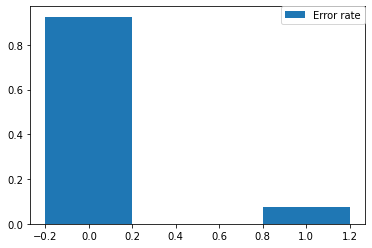

In [50]:
plt.bar(cnt.keys(), [v / sum(cnt.values()) for v in cnt.values()], width=0.4, label="Error rate")
plt.legend(bbox_to_anchor=(1, 1), loc="upper right", borderaxespad=0.)
plt.show()

Посмотрим на примеры из тестовой выборки, на которых модель ошиблась

TRUE        PRED        ERROR
------------------------------------


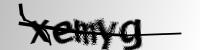

xemyg  -->  xenyg       m-->n   



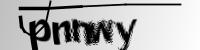

pnnwy  -->  pnnyy       w-->y   



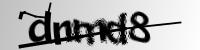

dnmd8  -->  gnmd8       d-->g   



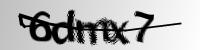

6dmx7  -->  6dmw7       x-->w   



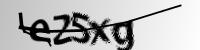

e25xg  -->  e25yg       x-->y   



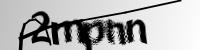

2mpnn  -->  2npnn       m-->n   



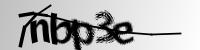

nbp3e  -->  nbp2e       3-->2   



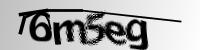

6m5eg  -->  6m6eg       5-->6   



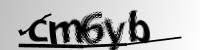

cm6yb  -->  cn6yb       m-->n   



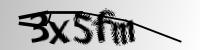

3x5fm  -->  3x5fn       m-->n   



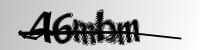

46mbm  -->  46nbm       m-->n   



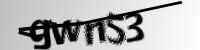

gwn53  -->  gwm53       n-->m   



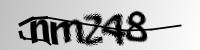

nm248  -->  nn248       m-->n   



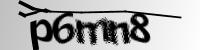

p6mn8  -->  p6mm8       n-->m   



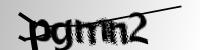

pgmn2  -->  pgmm2       n-->m   



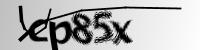

ep85x  -->  cp85x       e-->c   



In [51]:
print('TRUE        PRED        ERROR')
print('------------------------------------')
for cer in im_by_cer.keys():
    if cer == 0.: continue
    for true_lbl, pred_lbl in im_by_cer[cer]:
        try:
            img = Image.open(test_data_dir + true_lbl + '.png')
            display(img)
        except:
            img = Image.open(test_data_dir + true_lbl + '.jpg')
            display(img)
        
        print(f'{true_lbl}  -->  {pred_lbl}', end='       ')
        [print('-->'.join([a, b]), end='   ') for a, b in zip(true_lbl, pred_lbl) if a != b]
        print('\n')

Видно, что наиболее часто модель путает символы 'n' и 'm'. Возможно, тренировочная выборка несбалансирована по встречаемости различных символов. Проверим это 


In [38]:
symbols = Counter()

loader = DataLoader(train_dataset, batch_size=1)

for _, target in loader:
    symbols += Counter(alphabet.decode(target)[0])


In [39]:
print(symbols)

Counter({'n': 430, '4': 241, 'c': 232, 'm': 226, '5': 226, '6': 221, 'x': 217, '3': 216, '8': 215, 'd': 214, '2': 214, 'f': 213, 'w': 209, '7': 209, 'g': 208, 'b': 203, 'p': 198, 'e': 194, 'y': 194})


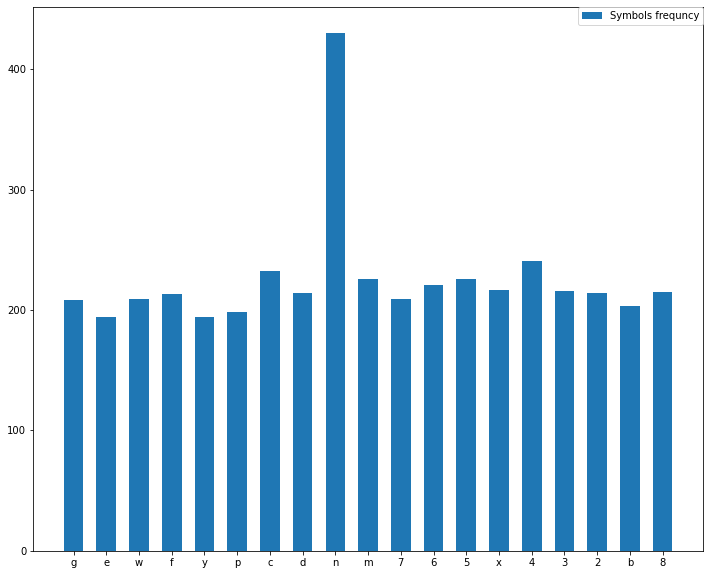

In [41]:
plt.figure(figsize=(12, 10))

plt.bar(symbols.keys(), symbols.values(), width=0.6, label="Symbols frequncy")
plt.legend(bbox_to_anchor=(1, 1), loc="upper right", borderaxespad=0.)
plt.show()

Действительно, символ 'n' встречается в 2 раза чаще остальных